In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(MODEL_OUT)

In [ ]:
!pip -q install timm pandas scikit-learn tqdm


In [ ]:
from pathlib import Path
import json, time, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

META_DIR = PROJECT_ROOT / "data/11_skin_type/metadata"
INDEX_CSV = META_DIR / "image_index_skin_type.csv"
LABEL_MAP_JSON = META_DIR / "label_map_skin_type.json"

MODEL_DIR = PROJECT_ROOT / "models/vision"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT / "results"
(RESULTS_DIR / "metrics").mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "confusion_matrices").mkdir(parents=True, exist_ok=True)

MODEL_OUT = MODEL_DIR / "skin_type_best.pt"
METRICS_OUT = RESULTS_DIR / "metrics/skin_type_metrics.json"
CM_OUT = RESULTS_DIR / "confusion_matrices/skin_type_confusion_matrix_counts.png"
CM_NORM_OUT = RESULTS_DIR / "confusion_matrices/skin_type_confusion_matrix_percent.png"

print("INDEX exists:", INDEX_CSV.exists(), INDEX_CSV)
print("LABEL exists:", LABEL_MAP_JSON.exists(), LABEL_MAP_JSON)


INDEX exists: True /content/drive/MyDrive/SkinCare_AI_Component/data/11_skin_type/metadata/image_index_skin_type.csv
LABEL exists: True /content/drive/MyDrive/SkinCare_AI_Component/data/11_skin_type/metadata/label_map_skin_type.json


In [ ]:
df = pd.read_csv(INDEX_CSV)

with open(LABEL_MAP_JSON, "r") as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

print("Classes:", label_map)
print("Total rows:", len(df))
df.head()


Classes: {'oily': 0, 'dry': 1, 'combination': 2}
Total rows: 7019


,image_path,label_name,label_id,split
0,data/11_skin_type/splits/test/oily/00705a62e3f...,oily,0,test
1,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
2,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
3,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
4,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test


In [ ]:
df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

print("Split sizes:", len(df_train), len(df_val), len(df_test))
assert len(df_train) > 0 and len(df_val) > 0 and len(df_test) > 0, "❌ Empty split!"


Split sizes: 4978 1008 1033


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4                # ✅ lower LR helps
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


Device: cuda


In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.15, 0.15, 0.10, 0.02)], p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [ ]:
class SkinTypeDataset(Dataset):
    def __init__(self, df_, tfm):
        self.df = df_.reset_index(drop=True)
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img_path = PROJECT_ROOT / r["image_path"]
        y = int(r["label_id"])
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        return x, y

train_ds = SkinTypeDataset(df_train, train_tfms)
val_ds   = SkinTypeDataset(df_val, eval_tfms)
test_ds  = SkinTypeDataset(df_test, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("✅ Loaders ready")


✅ Loaders ready


In [ ]:
from collections import Counter

counts = Counter(df_train["label_id"].tolist())
print("Train counts:", {id_to_label[k]: v for k, v in sorted(counts.items())})

class_weights = np.array([1.0 / counts.get(i, 1) for i in range(num_classes)], dtype=np.float32)
class_weights = class_weights / class_weights.sum() * num_classes
cw = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", {id_to_label[i]: float(class_weights[i]) for i in range(num_classes)})


Train counts: {'oily': 1764, 'dry': 2100, 'combination': 1114}
Class weights: {'oily': 0.876300573348999, 'dry': 0.7360924482345581, 'combination': 1.3876070976257324}


In [ ]:
MODEL_NAME = "convnext_tiny"   # ✅ usually better for texture than ViT on messy labels
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Warmup + cosine
total_steps = EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + np.cos(np.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

print("✅ Model:", MODEL_NAME, "| steps:", total_steps, "| warmup:", warmup_steps)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model: convnext_tiny | steps: 3120 | warmup: 312


/tmp/ipython-input-1161147672.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [ ]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            with torch.amp.autocast(device_type="cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # ✅ stability
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / max(total, 1), correct / max(total, 1)


In [ ]:
best_val = 0.0
best_epoch = 0
history = []
PATIENCE = 5
bad = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    history.append({
        "epoch": epoch,
        "train_loss": float(tr_loss),
        "train_acc": float(tr_acc),
        "val_loss": float(va_loss),
        "val_acc": float(va_acc),
    })

    print(f"Epoch {epoch}/{EPOCHS} | train acc {tr_acc:.4f} | val acc {va_acc:.4f}")

    if va_acc > best_val:
        best_val = va_acc
        best_epoch = epoch
        bad = 0
        torch.save({
            "model_state": model.state_dict(),
            "label_map": label_map,
            "model_name": MODEL_NAME,
            "img_size": IMG_SIZE
        }, MODEL_OUT)
        print("✅ Saved best:", MODEL_OUT, "val_acc:", best_val)
    else:
        bad += 1
        if bad >= PATIENCE:
            print(f"⏹️ Early stop. Best epoch={best_epoch}, best val={best_val:.4f}")
            break

print("✅ Done. Best val acc:", best_val)


  0%|          | 0/156 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/20 | train acc 0.5478 | val acc 0.4921
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_best.pt val_acc: 0.49206349206349204


Epoch 2/20 | train acc 0.7027 | val acc 0.5248
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_best.pt val_acc: 0.5248015873015873


Epoch 3/20 | train acc 0.7849 | val acc 0.5665
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_best.pt val_acc: 0.566468253968254


Epoch 4/20 | train acc 0.8515 | val acc 0.5813
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_best.pt val_acc: 0.5813492063492064


Epoch 5/20 | train acc 0.8847 | val acc 0.5387


Epoch 6/20 | train acc 0.9048 | val acc 0.5873
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_best.pt val_acc: 0.5873015873015873


Epoch 7/20 | train acc 0.9207 | val acc 0.5724


Epoch 8/20 | train acc 0.9275 | val acc 0.5734


Epoch 9/20 | train acc 0.9329 | val acc 0.5575


Epoch 10/20 | train acc 0.9434 | val acc 0.5714


Epoch 11/20 | train acc 0.9450 | val acc 0.5833
⏹️ Early stop. Best epoch=6, best val=0.5873
✅ Done. Best val acc: 0.5873015873015873


In [ ]:
ckpt = torch.load(MODEL_OUT, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(preds.tolist())

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
report = classification_report(y_true, y_pred, output_dict=True)

payload = {
    "model_name": ckpt.get("model_name", MODEL_NAME),
    "best_val_acc": float(best_val),
    "test_accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "report": report,
    "history": history
}

with open(METRICS_OUT, "w") as f:
    json.dump(payload, f, indent=2)

print("✅ Saved metrics:", METRICS_OUT)
print("Test Accuracy:", acc)
print("Macro F1:", macro_f1)


100%|██████████| 33/33 [02:17<00:00,  4.16s/it]


✅ Saved metrics: /content/drive/MyDrive/SkinCare_AI_Component/results/metrics/skin_type_metrics.json
Test Accuracy: 0.5711519845111326
Macro F1: 0.5517063942174489


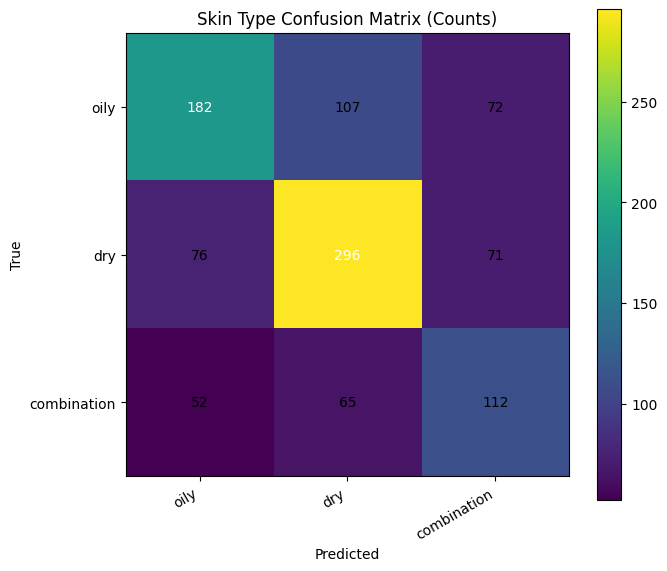

✅ Saved: /content/drive/MyDrive/SkinCare_AI_Component/results/confusion_matrices/skin_type_confusion_matrix_counts.png


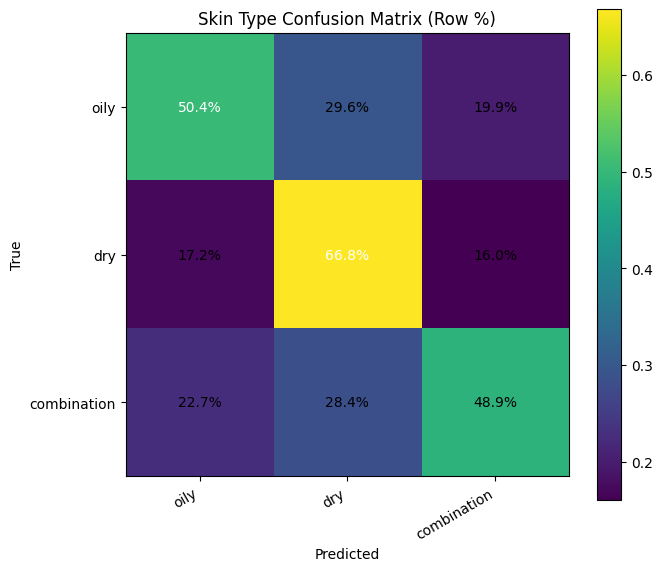

✅ Saved: /content/drive/MyDrive/SkinCare_AI_Component/results/confusion_matrices/skin_type_confusion_matrix_percent.png


In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
labels = [id_to_label[i] for i in range(num_classes)]
cm_np = np.array(cm)

# counts
plt.figure(figsize=(7,6))
plt.imshow(cm_np)
plt.title("Skin Type Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), labels, rotation=30, ha="right")
plt.yticks(range(num_classes), labels)
plt.colorbar()
th = cm_np.max() * 0.5 if cm_np.size else 0
for i in range(num_classes):
    for j in range(num_classes):
        v = int(cm_np[i, j])
        plt.text(j, i, str(v), ha="center", va="center",
                 color=("white" if v > th else "black"))
plt.tight_layout()
plt.savefig(CM_OUT, dpi=250, bbox_inches="tight")
plt.show()
print("✅ Saved:", CM_OUT)

# normalized %
cm_norm = cm_np / np.clip(cm_np.sum(axis=1, keepdims=True), 1, None)
plt.figure(figsize=(7,6))
plt.imshow(cm_norm)
plt.title("Skin Type Confusion Matrix (Row %)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), labels, rotation=30, ha="right")
plt.yticks(range(num_classes), labels)
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        v = cm_norm[i, j] * 100
        plt.text(j, i, f"{v:.1f}%", ha="center", va="center",
                 color=("white" if v > 50 else "black"))
plt.tight_layout()
plt.savefig(CM_NORM_OUT, dpi=250, bbox_inches="tight")
plt.show()
print("✅ Saved:", CM_NORM_OUT)
